# 🏥 Diabetes Prediction: A Comparative Analysis
**Author:** Mohamed Anis ATHMANE  
**Goal:** Predict whether a patient has diabetes based on diagnostic measurements.

In this project, we will:
1. **Clean the data:** Handle biologically impossible values (e.g., 0 glucose).
2. **Impute missing data:** Use advanced grouping techniques to fill gaps.
3. **Analyze features:** Visualize correlations and distributions.
4. **Compare models:** Evaluate Logistic Regression, KNN, SVM, Random Forest, and XGBoost.

**Key Focus:** We will demonstrate how **Data Preprocessing** and **Feature Scaling** directly impact the performance of Machine Learning models.

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score, accuracy_score
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### Data Exploring

In [2]:
data = pd.read_csv("./DATA/Pima_Indians_Diabetes_Database.csv")
pd.set_option("display.float_format", lambda x: "%.2f" % x)
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.60,0.63,50,1
1,1,85,66,29,0,26.60,0.35,31,0
2,8,183,64,0,0,23.30,0.67,32,1
3,1,89,66,23,94,28.10,0.17,21,0
4,0,137,40,35,168,43.10,2.29,33,1


In [3]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.00,768.00,768.00,768.00,768.00,768.00,768.00,768.00,768.00
mean,3.85,120.89,69.11,20.54,79.80,31.99,0.47,33.24,0.35
std,3.37,31.97,19.36,15.95,115.24,7.88,0.33,11.76,0.48
min,0.00,0.00,0.00,0.00,0.00,0.00,0.08,21.00,0.00
25%,1.00,99.00,62.00,0.00,0.00,27.30,0.24,24.00,0.00
50%,3.00,117.00,72.00,23.00,30.50,32.00,0.37,29.00,0.00
75%,6.00,140.25,80.00,32.00,127.25,36.60,0.63,41.00,1.00
max,17.00,199.00,122.00,99.00,846.00,67.10,2.42,81.00,1.00


### 🧹 Data Cleaning: The "Zero" Trap
Upon inspecting the data, we observed a critical issue: columns like `Glucose`, `Insulin`, and `BMI` contain `0` values.
* **Biologically Impossible:** A living human cannot have 0 blood sugar or 0 body mass.
* **Conclusion:** These zeros represent **missing data**, not real measurements.

**Action Plan:**
We will replace these zeros with `NaN` (Not a Number) to prevent them from skewing our statistical analysis and model training.

In [4]:
cols = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
data[cols] = data[cols].replace(0, np.nan)

In [5]:
for col in cols:
    data[col] = data[col].fillna(data.groupby("Outcome")[col].transform("median"))

### 📊 Exploratory Data Analysis (EDA)
Now that our data is clean, let's understand the relationships between variables.
**Goal:** Identify which features are the strongest predictors of Diabetes.

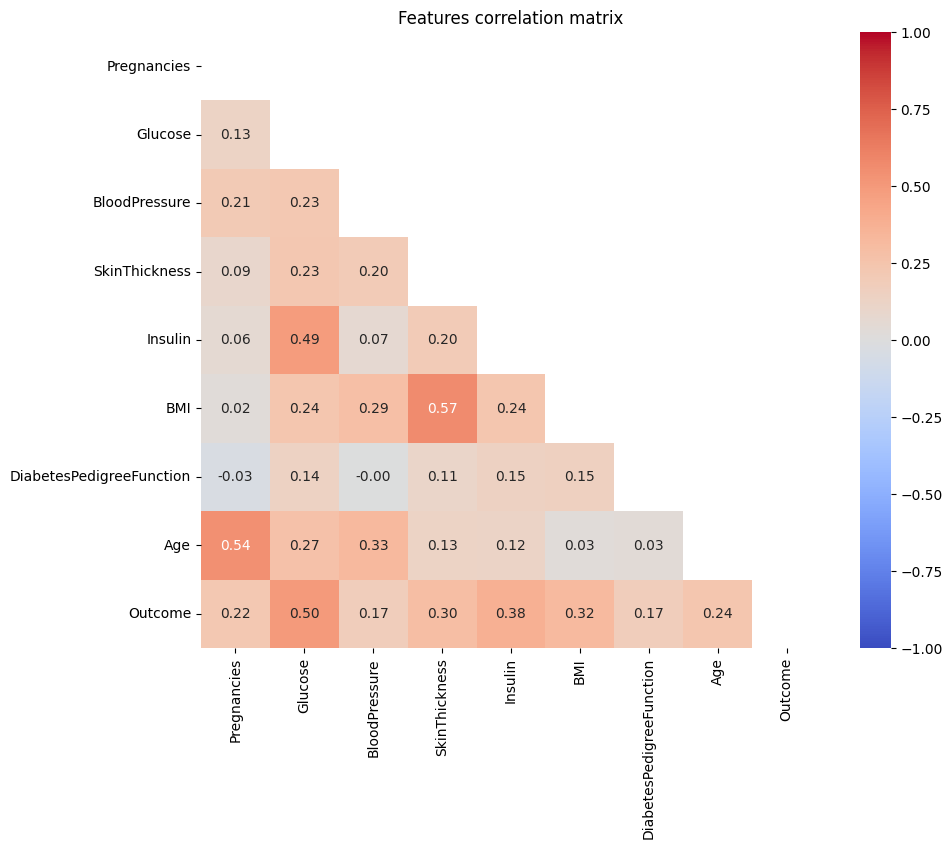

In [6]:
data_corr = data.corr()

mask = np.triu(np.ones_like(data_corr, dtype=bool))

plt.figure(figsize=(10, 8))
sns.heatmap(data_corr, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Features correlation matrix")
plt.show()

From the heatmap, we can see that the glucose rates have the highest correlation with the outcome (condition).


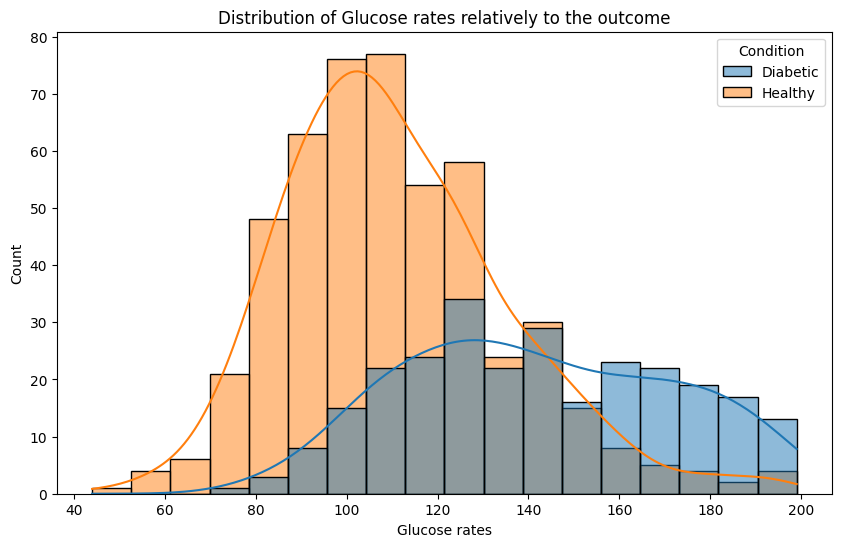

In [7]:
data["Condition"] = data['Outcome'].map({0: "Healthy", 1:"Diabetic"})

plt.figure(figsize=(10,6))
sns.histplot(data=data[["Glucose", "Condition"]], x="Glucose", hue="Condition", kde=True)
plt.xlabel("Glucose rates")
plt.title("Distribution of Glucose rates relatively to the outcome")
plt.show()

### 📉 Feature Distribution & Outliers
We use **Boxplots** to visualize how each feature differs between Healthy and Diabetic patients.

**What to look for:**
1. **Separation:** Do the boxes for Healthy vs. Diabetic overlap? (Less overlap = Better predictor).
2. **Outliers:** Are there extreme values (dots outside the whiskers) that might confuse our models?

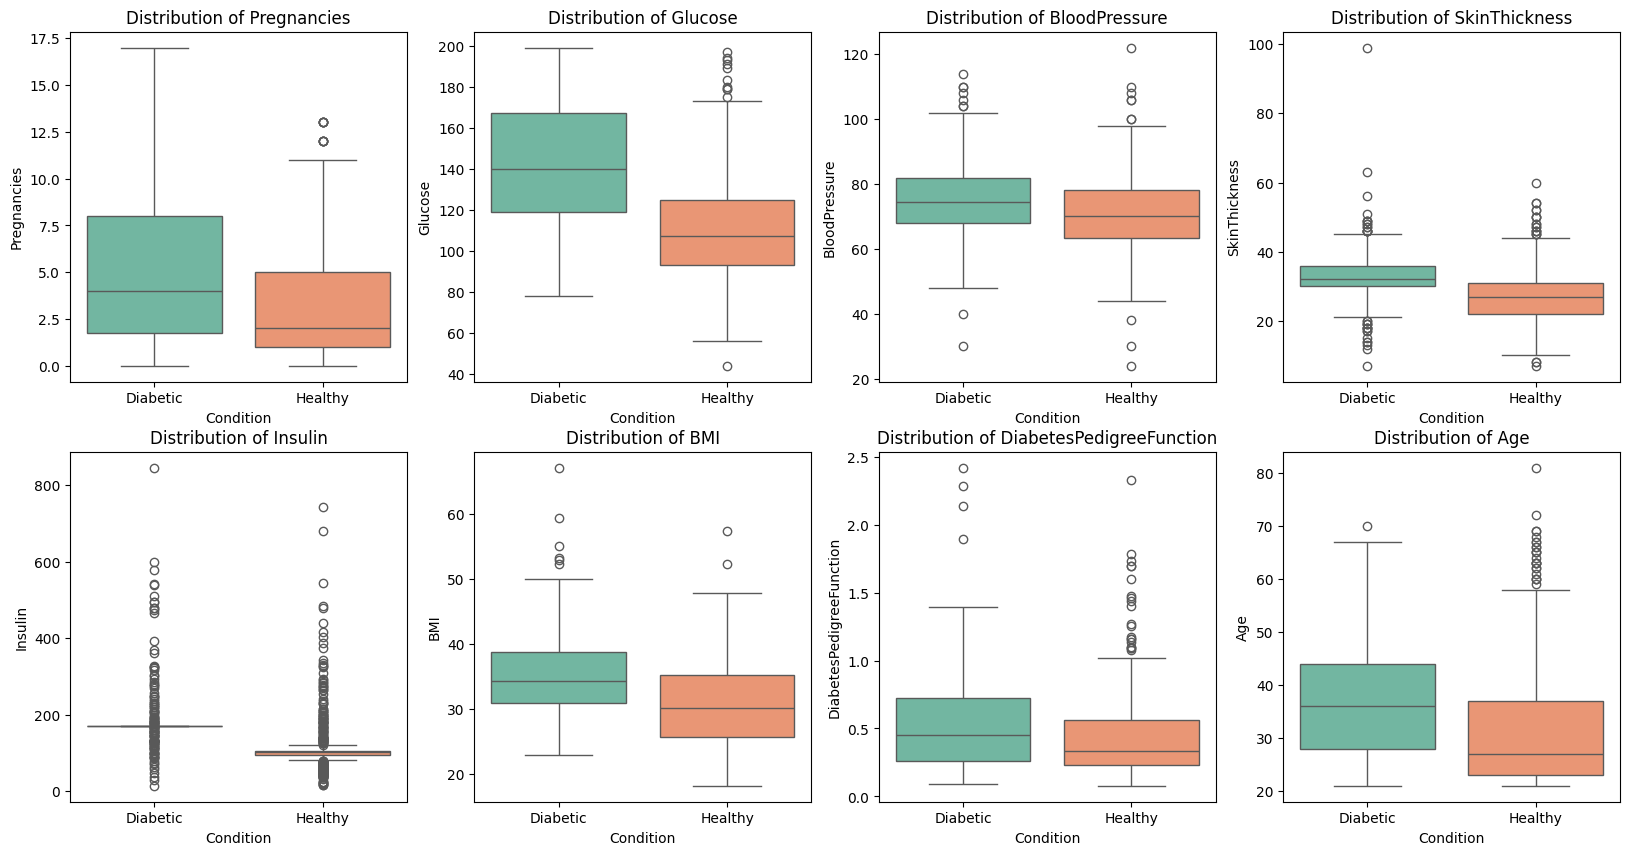

In [8]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
cols = list(data.columns)
cols.remove("Outcome")
cols.remove("Condition")
for i, column in enumerate(cols):
    row, col = i // 4, i % 4
    sns.boxplot(data=data[[column, "Condition"]], ax=axes[row, col], hue="Condition", x="Condition", y=column, palette="Set2", legend=False)
    axes[row, col].set_title(f"Distribution of {column}")

Skin thickness of 99 actually means over the limit of the tool used to mesure it 

In [9]:
data.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome', 'Condition'],
      dtype='object')

### 🤖 Machine Learning Pipeline
We will compare 5 different algorithms to see which one performs best.

**The Contenders:**
1. **Logistic Regression:** Our baseline (linear model).
2. **KNN (K-Nearest Neighbors):** Distance-based (highly sensitive to scaling).
3. **SVM (Support Vector Machine):** Good for finding complex boundaries.
4. **Random Forest:** Ensemble method (robust to outliers).
5. **XGBoost:** State-of-the-art gradient boosting.

**Methodology:**
* We split the data into **Training (80%)** and **Testing (20%)** sets.
* We use `stratify=y` to ensure both sets have the same proportion of diabetic patients.

In [10]:
models = {
    "Logistic Regression": LogisticRegression(),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(eval_metric="logloss", use_label_encoder=False)
}
X = data.drop(columns= ['Outcome', 'Condition'])
y = data["Outcome"] 
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True, random_state=42, stratify=y)

results = []

for name, model in models.items():
    if name in ["KNN", "SVM", "Logistic Regression"]:
        scaler = StandardScaler()
        X_train_loop = scaler.fit_transform(X_train)
        X_test_loop = scaler.transform(X_test)
        model.fit(X_train_loop, y_train)
        y_pred = model.predict(X_test_loop)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    results.append({
        "Model": name,
        'Accuracy': accuracy_score(y_true=y_test, y_pred=y_pred) * 100,
        "F1 Score": f1_score(y_true=y_test, y_pred=y_pred) * 100,
    })

c:\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [23:57:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [11]:
results = pd.DataFrame(data=results)
results

,Model,Accuracy,F1 Score
0,Logistic Regression,70.78,57.14
1,KNN,81.17,72.90
2,SVM,83.77,77.06
3,Random Forest,87.01,81.13
4,XGBoost,88.31,83.64


### 🏆 Project Conclusion
Our analysis highlights the importance of choosing the right model for the data.

**Key Findings:**
1. **Tree-based models (XGBoost, Random Forest)** performed the best, likely because they are robust to outliers and non-linear relationships.
2. **Data Cleaning mattered:** By correctly handling the zero values, we prevented the models from learning incorrect patterns.
3. **Feature Scaling (Note):** For distance-based models like KNN and SVM to reach their full potential, features should be scaled (e.g., using `StandardScaler`).

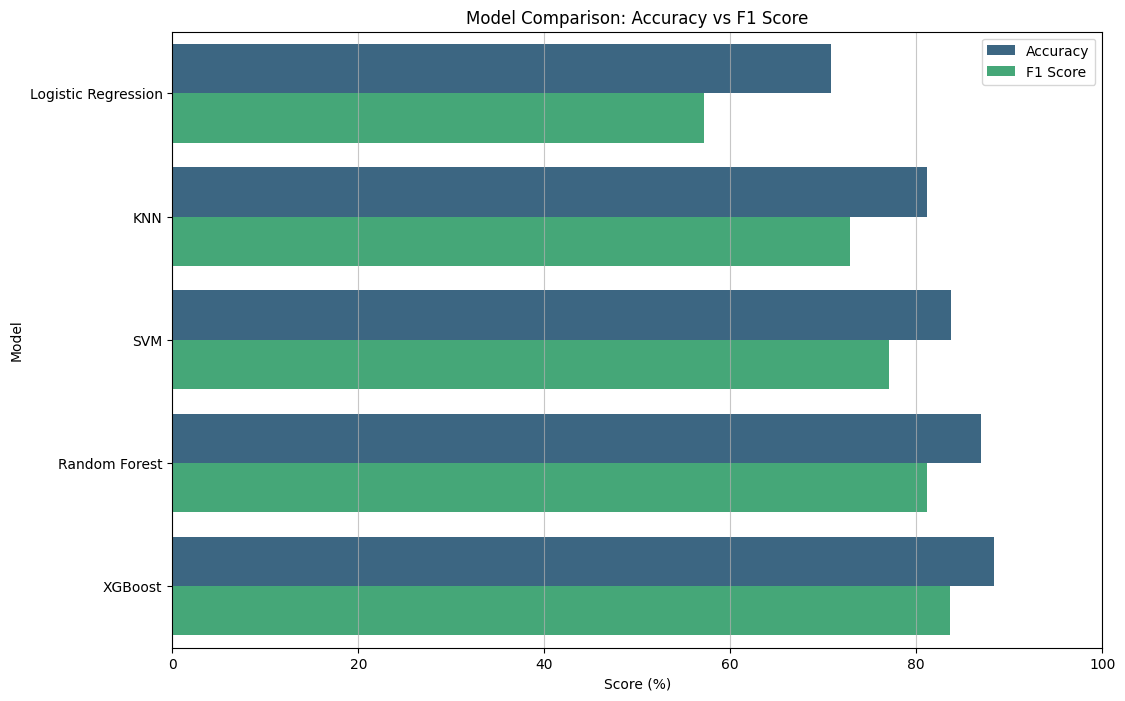

In [12]:
plt.figure(figsize=(12, 8))
results_melted = results.melt(id_vars="Model", var_name="Metric", value_name="Score")

sns.barplot(data=results_melted, x="Score", y="Model", hue="Metric", palette="viridis")

plt.title("Model Comparison: Accuracy vs F1 Score")
plt.xlabel("Score (%)")
plt.xlim(0, 100)
plt.grid(alpha=0.7, axis="x")
plt.legend(loc='upper right')

plt.show()